# Exercise 2 - R: Logistic Regression

## Part I: *Logistic regression without regularization*

Predicting if a student will be accepted into a university based off of two test scores

Beginning with package imports, data loading, and initial visualization

In [1]:
rm(list=ls())  # Clearing all environment variables

suppressPackageStartupMessages({
  library(readr)
  library(ggplot2)
  library(dplyr)
})

theme_update(plot.title = element_text(hjust = 0.5))  # Centers ggplot2 titles

Warning message:
"package 'readr' was built under R version 3.3.3"

In [2]:
df <- read_csv("ex2/ex2data1.txt",
                   col_names = FALSE,
                   col_types = 'ddd')

colnames(df) <- c('Exam1Score', 'Exam2Score', 'Admitted')

# Inserting ones for the intercept
df <- cbind(Intercept=1, df)

X <- df %>% select(-Admitted)
y <- df$Admitted

# An array of 0s for starting values of theta to be used in many functions
initialTheta <- c(0, 0, 0)

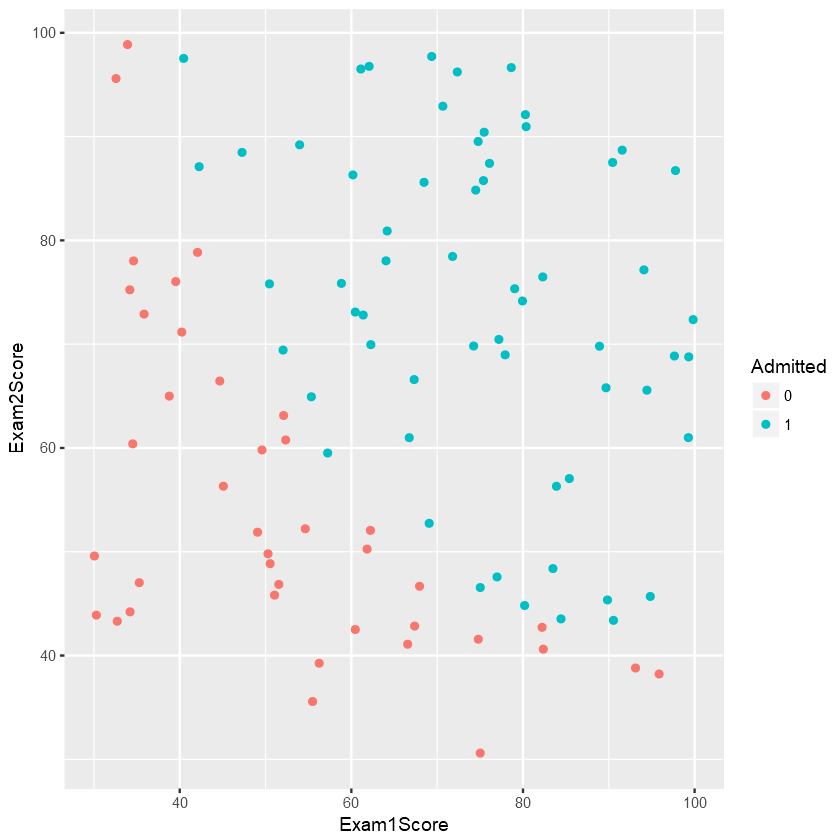

In [3]:
ggplot(df) +
  geom_point(aes(x=Exam1Score, y=Exam2Score, color=as.factor(Admitted))) + 
  labs(color='Admitted') 

### Sigmoid Function

$g(z) = \frac{1}{1+e^{-z}}$

Converts $z$ into a value between 0 and 1

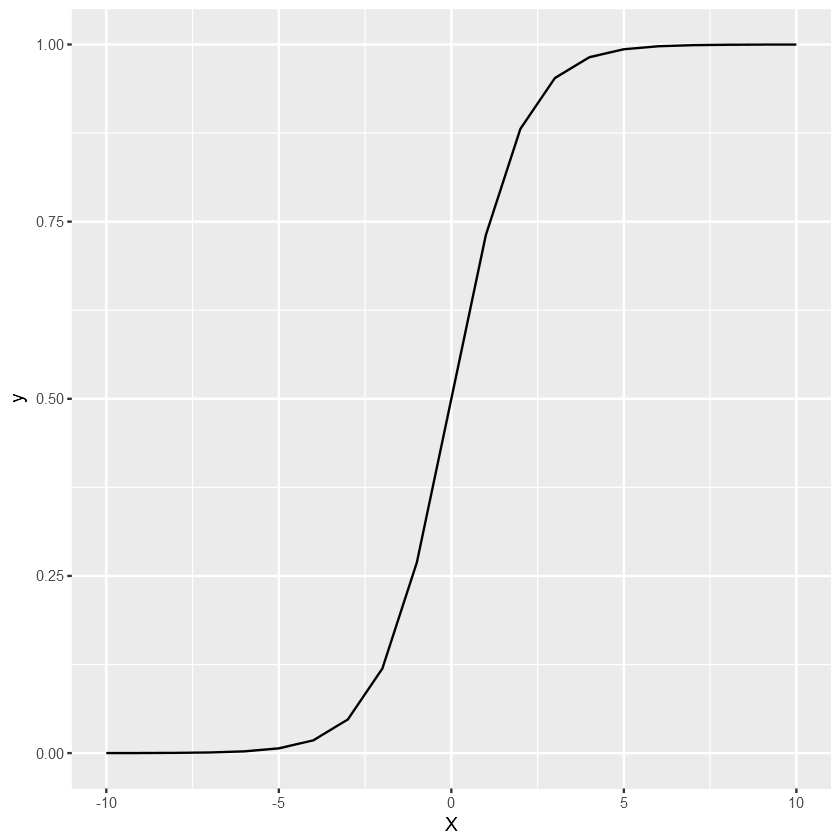

In [4]:
sigmoid <- function(z){
  # Converts numerical input into a value between 0 and 1 
  return(1/(1+exp(-z))) 
}

# Plotting to validate that the function is working
data.frame(X = -10:10) %>% 
  mutate(y = sigmoid(X)) %>% 
  ggplot() + 
    geom_line(aes(x=X, y=y))

### Logistic Regression Hypothesis

$h_\theta(x) = g(\theta^Tx)$

- Notation:

    - $g$: Sigmoid function

    - $\theta^T$: Transposed parameters
       
        - E.x.: $\theta^T = \begin{bmatrix} \theta_1 \\ \theta_2 \\ \vdots \\ \theta_n \end{bmatrix}$

In [5]:
logistic_hypothesis <- function(theta, X){
  # Calculates the hypothesis for X given values of
  # theta for logistic regression
  X <- as.matrix(X)
  theta <- as.matrix(theta)
  h <- X %*% theta
  return(sigmoid(h))
}

logistic_hypothesis(initialTheta, head(X))

1,0.5
2,0.5
3,0.5
4,0.5
5,0.5
6,0.5


### Cost Function

$J(\theta) = \frac{1}{m} \sum_{i=1}^m[-y^{(i)}log(h_\theta(x^{(i)})) - (1-y^{(i)})log(1-h_\theta(x^{(i)}))]$

- Notation:

    - $m$: Number of records

    - $h_\theta$: Logistic hypothesis $(h)$ given specific values of $\theta$ for parameters
    
    - $i$: Index of the record (e.x. if $i = 46$, then 46th row)

In [6]:
cost_function <- function(theta, X, y){
  # Computes cost for logistic regression
  m <- length(y)
  h <- logistic_hypothesis(theta, X)
  error <- sum(-y*log(h)-(1-y)*log(1-h))
  J <- (1/m)*error
  return(J)
}

cost_function(initialTheta, X, y)

[1] 0.6931472

### Gradient

$\frac{\partial J(\theta)}{\partial \theta_j} = \frac{1}{m} \sum_{i=1}^m (h_\theta(x^{(i)}) - y^{(i)})x_j^{(i)}$

- Notation:

    - $\partial$: Partial derivative
    
    - $J(\theta)$: Cost given $\theta$

    - $m$: Number of records
    
    - $h_\theta$: Logistic hypothesis $(h)$ given specific values of $\theta$ for parameters
    
    - $i$: Index of the record (e.x. if $i = 46$, then 46th row)

In [7]:
gradient <- function(theta, X, y){
  # Computes the gradient for logistic regression
  X <- as.matrix(X)
  y <- as.matrix(y)
  theta <- as.matrix(theta)
  
  m <- length(y)
  h <- logistic_hypothesis(theta, X)
  gradient <- (1/m) * (t(X) %*% (h-y))
  return(gradient)
}

gradient(initialTheta, X, y)

Intercept,-0.10000
Exam1Score,-12.00922
Exam2Score,-11.26284


Finding the optimal values of $\theta_j$ for the cost function using the base R optim function.  This is similar to MATLAB's fminunc function.

In [8]:
# Find values of theta that minimize the cost function
optimalTheta <- optim(
      # Specifying function parameters
      par=initialTheta,  # Initial guess
      fn=cost_function,  # Function to minimize
      X=X,
      y=y,
      method="BFGS",  #  Optimization function to use
      control = list(maxit = 400)  # Maximum number of iterations
     )$par  # Specifying that we only want the obtained thetas

# Pretty printing the obtained values for theta
cat('Cost:', x = cost_function(optimalTheta, X, y), '\n')
cat('\nOptimal Thetas\n',
    'Intercept:', optimalTheta[1], '\n',
    'Theta 1:', optimalTheta[2], '\n',
    'Theta 2:', optimalTheta[3])

Cost: 0.2034978 

Optimal Thetas
 Intercept: -25.18575 
 Theta 1: 0.2064298 
 Theta 2: 0.2016679

Comparing the obtained parameters to what base R's glm function provides

In [9]:
glm(Admitted ~ Exam1Score+Exam2Score, data=df, family=binomial)


Call:  glm(formula = Admitted ~ Exam1Score + Exam2Score, family = binomial, 
    data = df)

Coefficients:
(Intercept)   Exam1Score   Exam2Score  
   -25.1613       0.2062       0.2015  

Degrees of Freedom: 99 Total (i.e. Null);  97 Residual
Null Deviance:	    134.6 
Residual Deviance: 40.7 	AIC: 46.7

Not bad!

Calculating the class probability and generating predictions of acceptance using values of $\theta_j$ obtained from the optimization function

The outputs from logistic regression are just the class probability, or $P(y = 1 \mid x; \theta)$, so we are predicting the classes (accepted or not) as follows:

$Prediction(y \mid x; \theta) = \begin{cases} 1, \quad\mbox{ if } P(y = 1 \mid x; \theta) > 0.50 \\ 0, \quad\mbox{ if } P(y = 1 \mid x; \theta) \leq 0.50 \end{cases} $

In [10]:
# Predicting the class probability with the obtained thetas
df$ClassProbability <- logistic_hypothesis(optimalTheta, X)

# Assigning those with a class probability above 0.5 as admitted
df$Prediction <- ifelse(df$ClassProbability > 0.5, 1, 0)

head(df)

Intercept,Exam1Score,Exam2Score,Admitted,ClassProbability,Prediction
1,34.62366,78.02469,0,9.084887e-02,0
1,30.28671,43.89500,0,4.184675e-05,0
1,35.84741,72.90220,0,4.378303e-02,0
1,60.18260,86.30855,1,9.904669e-01,1
1,79.03274,75.34438,1,9.982096e-01,1
1,45.08328,56.31637,0,1.075034e-02,0


Plotting the decision boundary over the data

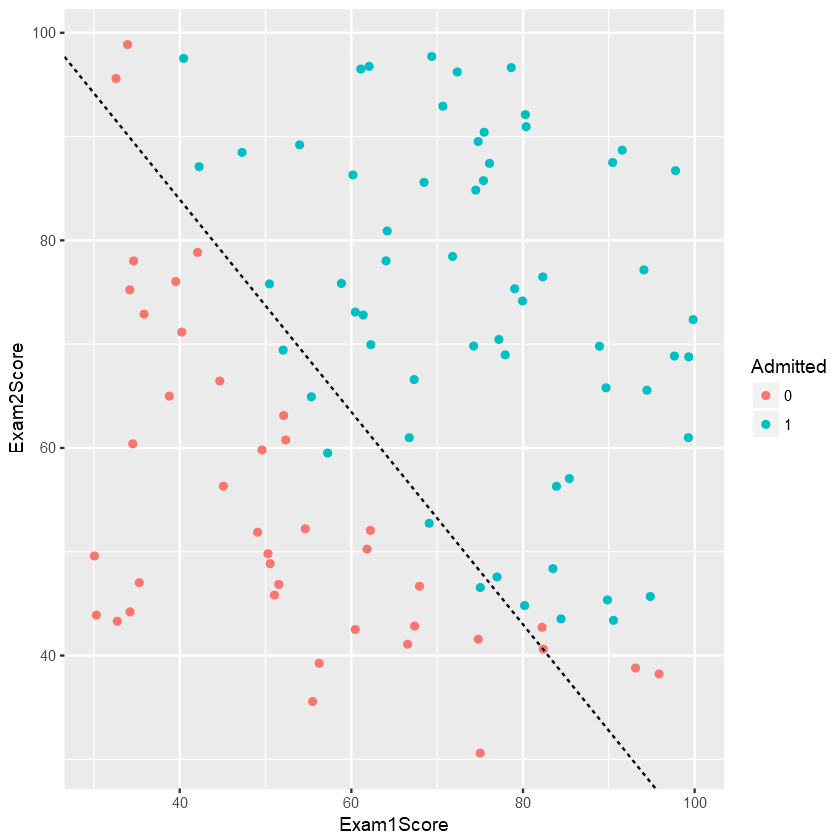

In [11]:
# Calculating and plotting the decision boundary
decisionSlope <- optimalTheta[2]/(-optimalTheta[3])
decisionIntercept <- optimalTheta[1]/(-optimalTheta[3]) 

ggplot(df) +
  geom_point(aes(x=Exam1Score, y=Exam2Score, color=as.factor(Admitted))) + 
  labs(color='Admitted') +
  geom_abline(intercept=decisionIntercept, slope=decisionSlope,
              linetype='dashed')

---

##  Part II: *Logistic regression with regularization*

Predicting if a microchip passes QA after two tests

In [12]:
df <- read_csv("ex2/ex2data2.txt",
                   col_names = FALSE,
                   col_types = 'ddd')

colnames(df) <- c('Test1', 'Test2', 'Accepted')

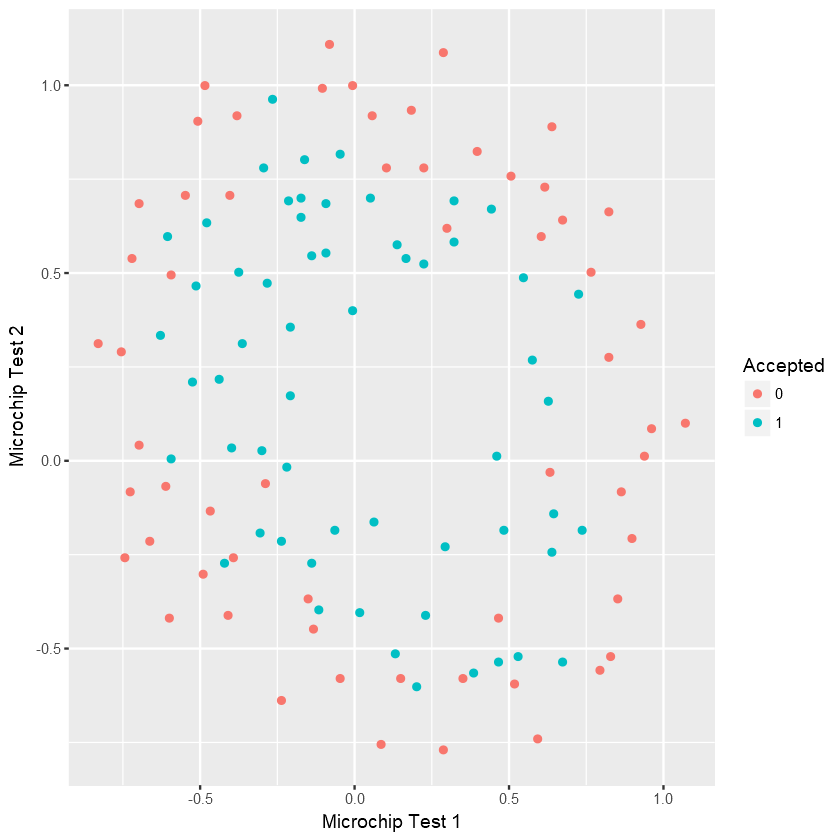

In [13]:
ggplot(df) +
  geom_point(aes(x=Test1, y=Test2, color=as.factor(Accepted))) + 
  labs(color='Accepted') +
  xlab('Microchip Test 1') + 
  ylab('Microchip Test 2')

### Feature Mapping

Maps the features into all polynomial terms of $x_1$ and $x_2$ up to the sixth power.  This allows for a more complex and nonlinear decision boundary.  

The feature space prior to feature mapping (3-dimensional vector): 

$\hspace{1cm} Feature(x) = \begin{bmatrix} 1 \\ x_1 \\ x_2 \end{bmatrix}$ 

The feature space after feature mapping:

$\hspace{1cm} mapFeature(x) = \begin{bmatrix} 1 \\ x_1 \\ x_2 \\ x_1^2 \\ x_1x_2 \\ x_2^2 \\ x_1^3 \\ \vdots \\ x_1x_2^5 \\ x_2^6 \end{bmatrix}$

**Note:** I made a few adjustments on the Octave/MATLAB code provided for this assignment in order to maintain the names of the polynomials

Octave/MATLAB code:
```
degree = 6;
out = ones(size(X1(:,1)));
for i = 1:degree
    for j = 0:i
        out(:, end+1) = (X1.^(i-j)).*(X2.^j);
    end
end
```

In [14]:
X <- df %>% select(Test1, Test2)
y <- df$Accepted

# Creating function for use in plotting decision boundaries later
mapFeatures <- function(X, degree) {
  # Creates polynomial features of X up to the degree specified
  for (i in 1:degree) {
    for (j in 0:i) {
      
      # Assigning names to the columns
      if (j == 0) {
        if (i == 1) {
          colName <- 'x1'
        } else {
            colName <- paste0('x1_', as.character(i))
        }
      } else if (i-j == 0) {
          if (j == 1) {
            colName <- 'x2'
          } else {
              colName <- paste0('x2_', as.character(j))
          }
      } else {
        colName <- paste0('x1_', as.character(i-j), ':', 'x2_', as.character(j))
      }
      
      # Calculating polynomial features
      X[colName] <- (X[, 1]^(i-j)) * (X[, 2]^j)
    }
  }
  
  X <- X[, 3:length(X)]  # Removing original columns to keep naming conventions
  X <- cbind(x0 = 1, X)  # Inserting the intercept term

  return(X)
}

X <- mapFeatures(X, 6)

# Creating a new list of initial thetas
initialTheta <- numeric(length(X))

print(dim(X))
head(X)

[1] 118  28


x0,x1,x2,x1_2,x1_1:x2_1,x2_2,x1_3,x1_2:x2_1,x1_1:x2_2,x2_3,...,x1_2:x2_3,x1_1:x2_4,x2_5,x1_6,x1_5:x2_1,x1_4:x2_2,x1_3:x2_3,x1_2:x2_4,x1_1:x2_5,x2_6
1,0.051267,0.69956,0.002628305,0.03586434,0.48938419,0.0001347453,0.001838657,0.02508926,0.342353606,...,0.0008998098,0.012278287,0.167542444,1.815630e-08,2.477505e-07,3.380660e-06,4.613055e-05,0.0006294709,0.0085893985,1.172060e-01
1,-0.092742,0.68494,0.008601079,-0.06352271,0.46914280,-0.0007976812,0.005891223,-0.04350924,0.321334672,...,0.0027638248,-0.020412048,0.150751849,6.362953e-07,-4.699318e-06,3.470651e-05,-2.563226e-04,0.0018930541,-0.0139810280,1.032560e-01
1,-0.213710,0.69225,0.045671964,-0.14794075,0.47921006,-0.0097605554,0.031616417,-0.10241198,0.331733166,...,0.0151509052,-0.049076853,0.158969871,9.526844e-05,-3.085938e-04,9.995978e-04,-3.237900e-03,0.0104882142,-0.0339734512,1.100469e-01
1,-0.375000,0.50219,0.140625000,-0.18832125,0.25219480,-0.0527343750,0.070620469,-0.09457305,0.126649705,...,0.0178101147,-0.023850831,0.031940396,2.780914e-03,-3.724126e-03,4.987251e-03,-6.678793e-03,0.0089440615,-0.0119776487,1.604015e-02
1,-0.513250,0.46564,0.263425562,-0.23898973,0.21682061,-0.1352031700,0.122661479,-0.11128318,0.100960349,...,0.0265955366,-0.024128486,0.021890284,1.827990e-02,-1.658422e-02,1.504584e-02,-1.365016e-02,0.0123839457,-0.0112351884,1.019299e-02
1,-0.524770,0.20980,0.275383553,-0.11009675,0.04401604,-0.1445130271,0.057775469,-0.02309830,0.009234565,...,0.0025430474,-0.001016696,0.000406469,2.088401e-02,-8.349308e-03,3.338005e-03,-1.334515e-03,0.0005335313,-0.0002133027,8.527719e-05


### Regularized Cost Function

$J(\theta) = \frac{1}{m} \sum_{i=1}^m[-y^{(i)}log(h_\theta(x^{(i)})) - (1-y^{(i)})log(1-h_\theta(x^{(i)}))] + \frac{\lambda}{2m} \sum_{j=1}^n \theta_j^2$

The only change from the other cost function we used earlier is the addition of the regularization parameter:

#### Regularization Parameter

$\frac{\lambda}{2m} \sum_{j=1}^n \theta_j^2$

- Notation:

    - $\lambda$: The weight which the parameters are adjusted by.  A lower $\lambda$ has little effect on the parameters, and a higher $\lambda$ (e.x. $\lambda = 1,000$) will adjust the parameters to be close to 0.
    - $m$: Number of records
    - $j$: The index for the parameter.  E.x. $\theta_{j=1}$ is the score for Microchip Test #1

**Note:** $\theta_0$ should not be regularized as denoted by the summation in the regularization parameter

In [15]:
regularized_cost <- function(theta, X, y, C){
  # Computes cost for logistic regression
  m <- length(y)
  h <- logistic_hypothesis(theta, X)
  error <- sum(-y*log(h)-(1-y)*log(1-h))
  
  # Calculating the regularization parameter
  # Avoiding the regularization parameter for the first theta
  regularizedTheta <- theta[-1] ** 2
  regularization <- (C/(2*m)) * sum(regularizedTheta)
  
  J <- (1/m)*error + regularization
  return(J)
}

# Testing how cost differs with regularization
# Using thetas above 0 so the regularization parameter has an impact
regTestTheta <- rep(0.5, length(X))
cat('Cost at lambda=0:', regularized_cost(regTestTheta, X, y, C=0), '\n')
cat('Cost at lambda=1:', regularized_cost(regTestTheta, X, y, C=1), '\n')
cat('Cost at lambda=100:', regularized_cost(regTestTheta, X, y, C=100))

Cost at lambda=0: 1.231531 
Cost at lambda=1: 1.260133 
Cost at lambda=100: 4.091701

### Regularized Gradient

$\frac{\partial J(\theta)}{\partial \theta_j} = \begin{cases} 
\hspace{0.25cm} \frac{1}{m} \sum_{i=1}^m (h_\theta(x^{(i)}) - y^{(i)})x_j^{(i)} & \text{for}\ j = 0 \\
\Big(\frac{1}{m} \sum_{i=1}^m (h_\theta(x^{(i)}) - y^{(i)})x_j^{(i)}\Big) + \frac{\lambda}{m}\theta_j & \text{for}\ j \geq 1
\end{cases}$


This is also the same as the last gradient with the exception of the regularization parameter

#### Regularization Parameter

$\frac{\lambda}{m}\theta_j \hspace{0.5cm}$for $j \geq 1$

- Notation:

    - $\lambda$: The weight which the parameters are adjusted by.  A lower $\lambda$ has little effect on the parameters, and a higher $\lambda$ (e.x. $\lambda = 1,000$) will adjust the parameters to be close to 0.
    - $m$: Number of records
    - $j$: The index for the parameter.  E.x. $\theta_{j=1}$ is the score for Microchip Test #1

In [16]:
regularized_gradient <- function(theta, X, y, C){
  # Computes the gradient for logistic regression
  X <- as.matrix(X)
  y <- as.matrix(y)
  theta <- as.matrix(theta)
  m <- length(y)
  h <- logistic_hypothesis(theta, X)
    
  # Calculating the regularization parameter for all thetas but the intercept
  regParam <- (C/m) * theta[-1]
    
  gradient <- (1/m) * (t(X) %*% (h-y))
  gradient[-1] <- gradient[-1] + regParam
  return(gradient)
}

t(regularized_gradient(initialTheta, X, y, C=1.0))

x0,x1,x2,x1_2,x1_1:x2_1,x2_2,x1_3,x1_2:x2_1,x1_1:x2_2,x2_3,...,x1_2:x2_3,x1_1:x2_4,x2_5,x1_6,x1_5:x2_1,x1_4:x2_2,x1_3:x2_3,x1_2:x2_4,x1_1:x2_5,x2_6
0.008474576,0.01878809,7.777119e-05,0.05034464,0.01150133,0.03766485,0.01835599,0.007323934,0.008192445,0.02347649,...,0.005838221,0.004476291,0.03100798,0.03103124,0.001097402,0.006315708,0.000408503,0.007265043,0.001376462,0.03879364


Finding the optimal values of $\theta$.  This chunk is surprisingly much quicker than the similar function I used in Python.

In [17]:
# Find values of theta that minimize the cost function
optimalTheta <- optim(
      # Specifying function parameters
      par=initialTheta,  # Initial guess
      fn=regularized_cost,  # Function to minimize
      X=X,
      y=y,
      C=1.0,
      method="BFGS",  #  Optimization function to use
      control = list(maxit = 4000)  # Maximum number of iterations
     )$par  # Specifying that we only want the obtained thetas

Checking against R's glm logistic regression.  This is an unregularized approach, but since we used a blanket value of lambda, there shouldn't be a huge difference.

In [18]:
# Fitting the model
model <- glm(y ~ ., data=cbind(X[, -1], y), family='binomial')
modelCoef <- model$coefficients %>% data.frame(glm=.)

cbind(modelCoef, optimalTheta) %>% t()

Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"

,(Intercept),x1,x2,x1_2,`x1_1:x2_1`,x2_2,x1_3,`x1_2:x2_1`,`x1_1:x2_2`,x2_3,...,`x1_2:x2_3`,`x1_1:x2_4`,x2_5,x1_6,`x1_5:x2_1`,`x1_4:x2_2`,`x1_3:x2_3`,`x1_2:x2_4`,`x1_1:x2_5`,x2_6
glm,38.230847,55.5958326,98.146665,-369.430187,-177.1204356,-194.260596,-366.0086744,-842.2108446,-719.4482402,-511.8945846,...,2919.0669170,1780.6082858,785.3150404,-1257.913141,-2.260005e+03,-4142.7959191,-4.290593e+03,-4229.6511669,-2055.548429,-750.3814488
optimalTheta,1.272684,0.6255774,1.180935,-2.019187,-0.9175743,-1.431917,0.1237623,-0.3651538,-0.3570543,-0.1748202,...,-0.2778296,-0.2952698,-0.4561123,-1.043812,2.761362e-02,-0.2926708,1.542143e-02,-0.3276022,-0.143895,-0.9246039


R's glm produced much more extreme values than our implementation.  We'll see how this affects the performance.

Lastly, comparing the accuracy between the two models.  Classification accuracy is just the percentage of records correctly classified (precision, recall, f-1 score, etc. offer more nuanced information on performance), so we will have to calculate the class probabilities and assign predictions like we did for part one:

In [19]:
# Predicting the class probability with the obtained thetas
df$ClassProbability <- logistic_hypothesis(optimalTheta, X)
df$glmClassProbability <- predict(model, X)

# Assigning those with a class probability above 0.5 as admitted
df$Prediction <- ifelse(df$ClassProbability > 0.5, 1, 0)
df$glmPrediction <- ifelse(df$glmClassProbability > 0.5, 1, 0)

head(df)

Test1,Test2,Accepted,ClassProbability,glmClassProbability,Prediction,glmPrediction
0.051267,0.69956,1,0.6986846,2.010320,1,1
-0.092742,0.68494,1,0.7181475,5.859164,1,1
-0.213710,0.69225,1,0.6997420,5.262569,1,1
-0.375000,0.50219,1,0.7297412,8.816580,1,1
-0.513250,0.46564,1,0.6504496,3.185247,1,1
-0.524770,0.20980,1,0.6241238,1.002604,1,1


In [20]:
ourAccuracy <- mean(ifelse(df$Accepted == df$Prediction, 1, 0))
glmAccuracy <- mean(ifelse(df$Accepted == df$glmPrediction, 1, 0))

cat('Our accuracy:', ourAccuracy, '\n')
cat('R\'s glm accuracy:', glmAccuracy)

Our accuracy: 0.8305085 
R's glm accuracy: 0.8728814

Our model had a lower accuracy, but it still did relatively well.

Plotting the decision boundary using inspiration from [this post](http://www.onthelambda.com/2014/07/24/interactive-visualization-of-non-linear-logistic-regression-decision-boundaries-with-shiny/)

   user  system elapsed 
 111.67    0.27  125.81 

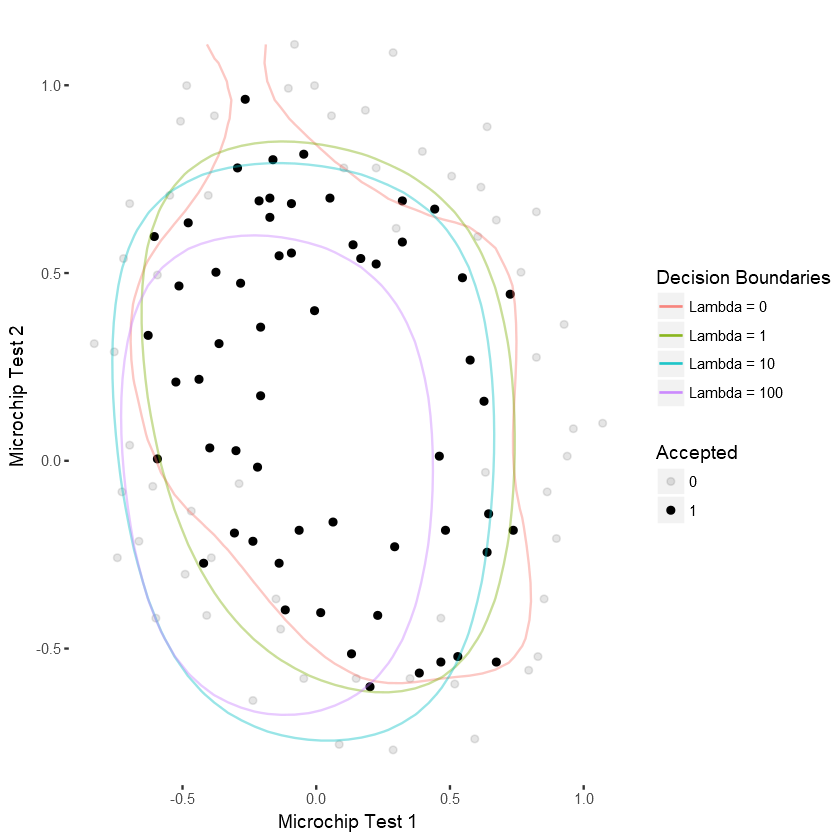

In [21]:
# Timing this cell
timeStart <- proc.time()

createBoundary <- function(X, y, C=0) {
  # Returns a data frame used for plotting the decision boundary.
  # Uses the optimization function to find the optimal values of
  # theta, so it is not needed as a parameter.

  # Find values of theta that minimize the cost function
  initialTheta <- numeric(length(X))
  optimalTheta <- optim(
        # Specifying function parameters
        par=initialTheta,  # Initial guess
        fn=regularized_cost,  # Function to minimize
        X=X,
        y=y,
        C=C,
        method="BFGS",  #  Optimization function to use
        control = list(maxit = 4000)  # Maximum number of iterations
       )$par  # Specifying that we only want the obtained thetas

  # Creating a mesh grid to generate class probabilities for  
  grid <- data.frame()
  dx <- seq(min(df$Test1), max(df$Test1), by=0.05)
  dy <- seq(min(df$Test2), max(df$Test2), length.out=length(dx))

  # Filling the grid with values
  for (i in 1:length(dx)) {
      for (j in 1:length(dx)) {
          v <- t(matrix(c(dx[i], dy[j])))
          grid <- rbind(grid, v)
      }
  }

  # Generating class probabilities on the polynomial features
  grid <- mapFeatures(grid, 6)  # Creating polynomial features
  grid$z <- logistic_hypothesis(optimalTheta, grid)  # Class probabilities
  grid <- grid %>% select(x1, x2, z)  # Removing polynomial features

  return(grid)
}

# Generating the decision boundaries for various levels of lambda
lambda0 <- createBoundary(X, y)
lambda1 <- createBoundary(X, y, 1)
lambda10 <- createBoundary(X, y, 10)
lambda100 <- createBoundary(X, y, 100)

# Plotting the original data
ggplot() +
  geom_point(data=df, aes(x=Test1, y=Test2,
                      # Using alpha instead of color to clean up legend
                      alpha=as.factor(df$Accepted))) + 
  xlab('Microchip Test 1') + 
  ylab('Microchip Test 2') +
  
  # Plotting the decision boundaries
  geom_contour(data=lambda0, aes(x=x1, y=x2, z=z, color='Lambda = 0'),
               breaks=0.5, alpha=0.4) + 
  geom_contour(data=lambda1, aes(x=x1, y=x2, z=z, color='Lambda = 1'),
               breaks=0.5, alpha=0.4) + 
  geom_contour(data=lambda10, aes(x=x1, y=x2, z=z, color='Lambda = 10'),
               breaks=0.5, alpha=0.4) + 
  geom_contour(data=lambda100, aes(x=x1, y=x2, z=z, color='Lambda = 100'),
               breaks=0.5, alpha=0.4) + 
  labs(alpha='Accepted', color='Decision Boundaries') + 
  theme(panel.background = element_blank())  # To aid in seeing rejected points

# Reporting time results
timeStop <- proc.time()
timeStop - timeStart